In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
# torhc dataset
from torch.utils.data import Dataset, DataLoader

# train test split
from sklearn.model_selection import train_test_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

#import summary for models
from torchsummary import summary

import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import matplotlib.pyplot as plt

In [2]:
all_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv", index_col=0).drop("Unnamed: 122",axis=1)
test_data = pd.read_csv("../Data/Test_Set_EEG.csv", index_col=0)
test_data = test_data.drop(['sex','eeg.date','education'], axis=1)
data = all_data.drop(['sex','eeg.date','education','main.disorder'], axis=1).dropna(axis=0)

# Encode disorders
encoder = OrdinalEncoder()
data[['specific.disorder']] = encoder.fit_transform(data[['specific.disorder']])

X = data.drop(['specific.disorder'], axis=1).dropna(axis=0)
y = data['specific.disorder']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
bands = ['gamma', 'highbeta', 'beta', 'alpha', 'theta', 'delta']
bands2 = ['F.gamma', 'E.highbeta', 'D.beta', 'C.alpha', 'B.theta', 'A.delta']

# Separate column names based on whether they are PSD or coherence
AB_per_band = {}
AB_cols = []
COH_per_band = {}
COH_cols = []

for band in bands:
    AB_per_band[band] = []
    COH_per_band[band] = []

for col_name in X_train.drop(['age','IQ'], axis=1).columns:
    col_split = col_name.split('.')
    if col_split[0] == 'AB':
        AB_per_band[col_split[2]].append(col_name)
        AB_cols.append(col_name)
    else:
        COH_per_band[col_split[2]].append(col_name)
        COH_cols.append(col_name)

In [4]:
# Get all electrode names
electrodes = set()
for col in COH_cols:
    col_split = col.split('.')
    # elec1 = col_split[4]
    electrodes.add(col_split[3]+'.'+col_split[4])
    # elec2 = col_split[6]
    electrodes.add(col_split[5]+'.'+col_split[6])

electrodes = list(electrodes)
len(electrodes)

19

## data preprocessing
coherence data shape = [num individuals, frequency bands, electrodes, electrodes]
PSD data shape = [num individuals, frequency bands, electrodes]

In [5]:
num_samples = X_train.shape[0]
num_nodes = len(electrodes)
num_bands = len(bands)

In [6]:
def getCoherenceStacked(coherence):
    adj_tensors = []

    # for each individual
    for i in range(coherence.shape[0]):
        indiv_tensors = []

        # for each band
        for band_idx in range(len(bands2)):
            # adjacency matrix electrodes x electrodes
            adj_matrix = np.zeros([len(electrodes),len(electrodes)])

            for elec1 in range(len(electrodes)):
                for elec2 in range(elec1+1, len(electrodes)):
                    col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec1]+'.'+electrodes[elec2]
                    if col_name in coherence.columns:
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
                    else: 
                        col_name = 'COH.'+bands2[band_idx]+'.'+electrodes[elec2]+'.'+electrodes[elec1]
                        adj_matrix[elec1][elec2] = coherence.iloc[i,:][col_name] #individual's row, then get value
            indiv_tensors.append(torch.from_numpy(adj_matrix).fill_diagonal_(1.0))

        adj_tensors.append(torch.stack(indiv_tensors))
    
    adj_matrices = torch.stack(adj_tensors)
    # print(adj_matrices.shape)
    adj_matrices = (adj_matrices + adj_matrices.transpose(2, 3)) / 2  # Ensure symmetry
    print(adj_matrices.shape)
    return adj_matrices

In [7]:
def getPSDStacked(psd):
    psd_tensors = []
    # for each individual
    for i in range(psd.shape[0]):
        psd_mat = np.zeros([len(electrodes),len(bands2)])

        # for each band
        for band_idx in range(len(bands2)):
            for elec1 in range(len(electrodes)):
                col_name = 'AB.'+bands2[band_idx]+'.'+electrodes[elec1]
                psd_mat[elec1][band_idx] = psd.iloc[i,:][col_name] #individual's row, then get value
            
        psd_tensors.append(torch.from_numpy(psd_mat))

    node_features = torch.stack(psd_tensors)
    print(node_features.shape)
    return node_features

In [8]:
adj_matrices = getCoherenceStacked(X_train)
adj_matrices_val = getCoherenceStacked(X_val)
adj_matrices_test = getCoherenceStacked(test_data)

torch.Size([672, 6, 19, 19])
torch.Size([168, 6, 19, 19])
torch.Size([93, 6, 19, 19])


In [9]:
node_features = getPSDStacked(X_train)
node_features_val = getPSDStacked(X_val)
node_features_test = getPSDStacked(test_data)

torch.Size([672, 19, 6])
torch.Size([168, 19, 6])
torch.Size([93, 19, 6])


In [10]:
print(type(y_val))

<class 'pandas.core.series.Series'>


In [11]:
# create data loaders from adj_matrices and node_features
class EEGDataset(Dataset):
    def __init__(self, adj_matrices, node_features, labels):
        self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
        self.node_features = torch.tensor(node_features, dtype=torch.float32)
        self.labels = torch.tensor(labels.to_list(), dtype=torch.long)
        if len(self.adj_matrices) != len(self.labels):
            raise ValueError("Adjacency matrices and labels must have the same length: {} != {}".format(len(self.adj_matrices), len(self.labels)))
        if len(self.node_features) != len(self.labels):
            raise ValueError("Node features and labels must have the same length: {} != {}".format(len(self.node_features), len(self.labels)))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.node_features[idx], self.labels[idx]

print(adj_matrices.shape)
train_dataset = EEGDataset(adj_matrices, node_features, y_train)
val_dataset = EEGDataset(adj_matrices_val, node_features_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dataset = EEGDataset(adj_matrices_test, node_features_test, labels = pd.Series([0] * 93))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([672, 6, 19, 19])


/var/folders/gh/81jb5jm510s1j8bqbbdb5htc0000gn/T/ipykernel_43658/3168603088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.adj_matrices = torch.tensor(adj_matrices, dtype=torch.float32)
/var/folders/gh/81jb5jm510s1j8bqbbdb5htc0000gn/T/ipykernel_43658/3168603088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.node_features = torch.tensor(node_features, dtype=torch.float32)


## modeling

### graph construction

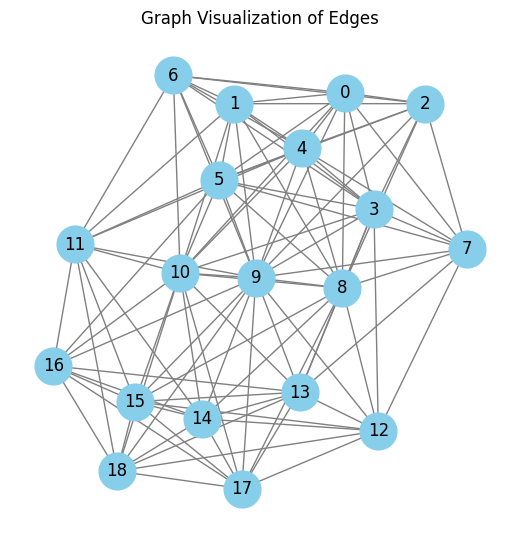

In [12]:
import networkx as nx

EDGES_PER_NODE = 10

real_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv")
only_coh_cols = [col for col in real_data.columns if "COH" in col]
psd = real_data[only_coh_cols]

band_coh = [np.zeros((19, 19)) for _ in range(6)]
for col in psd.columns:
    loc1, loc2 = col.split(".")[3], col.split(".")[5]
    band = ord(col.split(".")[1]) - ord('A')
    band_coh[band][ord(loc1)-97,ord(loc2)-97] += psd[col].mean()
    band_coh[band][ord(loc2)-97,ord(loc1)-97] += psd[col].mean()

band_coh = np.array(band_coh)
band_coh_max = np.max(band_coh, axis=0)

# Find the indices of the top 10 values in band_coh_max, a 2D numpy array of shape (19, 19)

np.array(np.unravel_index(np.argsort(band_coh_max, axis=None), band_coh_max.shape)).transpose()[-1:-4:-1]
# np.array(np.unravel_index(np.argsort(band_coh_max, axis=None), band_coh_max.shape)).transpose()[-50:]

edges = []
for i in range(19):
    edges.append(np.array(np.argsort(band_coh_max[i], axis=None)).transpose()[-1:-1 * EDGES_PER_NODE:-1])
edges = np.array(edges)
edges

edge_pairs = []

# Make a graph visualization of these edges
G = nx.Graph()

# Add nodes
for i in range(19):
    G.add_node(i)

# Add edges
for i, edge_list in enumerate(edges):
    for j in edge_list:
        G.add_edge(i, j)
        if i < j:
            edge_pairs.append((i,j))

# Draw the graph
plt.figure(figsize=(5,5))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
plt.title("Graph Visualization of Edges")
plt.show()

In [18]:
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

edge_index = torch.tensor(edge_pairs).transpose(0,1)
# make edge_index with dims [2,29] into shape [2,29,6] by copying

edge_attr = torch.tensor([band_coh_max[edge] / np.max(band_coh_max) for edge in edge_pairs], dtype=torch.float32)
data = Data(x=train_dataset.node_features, edge_index=edge_index, edge_attr=edge_attr)

# Define GNN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels=6, hidden_channels=16, out_channels=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 4)
        self.conv3 = GCNConv(hidden_channels * 4, out_channels)
        
        # convert batch_size x 19 x out_channels to batch_size x out_channels by making 19 layers connect to one of the 64
        self.fc1 = nn.Linear(out_channels * 19, out_channels * 19 // 8)
        self.fc2 = nn.Linear(out_channels * 19 // 8, hidden_channels * 2)
        self.fc3 = nn.Linear(hidden_channels * 2, 12)
        
        self.bn1 = nn.BatchNorm1d(out_channels * 19 // 8)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        
        self.dropout = nn.Dropout(p=0.06)

    def forward(self, x, edge_index, edge_attr):
        # Apply GCNConv layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc1(torch.flatten(x, start_dim=1))
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# The number of input channels should match the number of features in node_features
in_channels = node_features.shape[2]
model = GCN(in_channels=in_channels)

out = model(data.x[:3], data.edge_index, data.edge_attr)
out.shape

torch.Size([3, 12])

In [19]:
# Print the model
print(model)
# how many parameters?
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

GCN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 64)
  (conv3): GCNConv(64, 128)
  (fc1): Linear(in_features=2432, out_features=304, bias=True)
  (fc2): Linear(in_features=304, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=12, bias=True)
  (bn1): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.06, inplace=False)
)
759980


In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=0.00004,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 1e-5,
                              verbose = True)

In [21]:
print(len(train_dataset))
print(len(train_loader))

672
21


In [22]:
best_loss = np.inf
patience = 20
min_delta = 0.01
early_stop_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []
final_epoch = 0

num_epochs = 300

for epoch in range(num_epochs):

    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data

        optimizer.zero_grad()  # zero gradients

        outputs = model.forward(inputs, edge_index, edge_attr)  # input net

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()

        outputs = F.softmax(outputs, dim=1)
        top_p, top_class = outputs.topk(k=1, dim=1)

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().sum()
        running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_dataset)
    train_accs.append(epoch_accuracy)

    if epoch % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}")
    train_losses.append(epoch_loss)

    # val
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(inputs, edge_index, edge_attr)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    if epoch % 5 == 0:
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)


    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0
        #best_model_state = model.state_dict()
    else:
        early_stop_counter += 1

    # if early_stop_counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}.")
    #     final_epoch = epoch+1
    #     #model.load_state_dict(best_model_state)
    #     break

    scheduler.step(val_loss)

Epoch [1/300], Loss: 2.4606, Acc: 0.1190
Validation Loss: 2.4585, Validation Accuracy: 0.1094

Epoch [6/300], Loss: 2.3622, Acc: 0.1964
Validation Loss: 2.4125, Validation Accuracy: 0.1406

Epoch [11/300], Loss: 2.3343, Acc: 0.1935
Validation Loss: 2.4089, Validation Accuracy: 0.1354

Epoch [16/300], Loss: 2.3178, Acc: 0.2217
Validation Loss: 2.4101, Validation Accuracy: 0.1302

Epoch [21/300], Loss: 2.3167, Acc: 0.2128
Validation Loss: 2.4023, Validation Accuracy: 0.1250

Epoch [26/300], Loss: 2.3034, Acc: 0.2158
Validation Loss: 2.3970, Validation Accuracy: 0.1302

Epoch [31/300], Loss: 2.2914, Acc: 0.2202
Validation Loss: 2.3884, Validation Accuracy: 0.1354

Epoch [36/300], Loss: 2.2792, Acc: 0.2292
Validation Loss: 2.3814, Validation Accuracy: 0.1354

Epoch [41/300], Loss: 2.2687, Acc: 0.2366
Validation Loss: 2.3782, Validation Accuracy: 0.1510

Epoch [46/300], Loss: 2.2701, Acc: 0.2515
Validation Loss: 2.3919, Validation Accuracy: 0.1302

Epoch [51/300], Loss: 2.2619, Acc: 0.2381


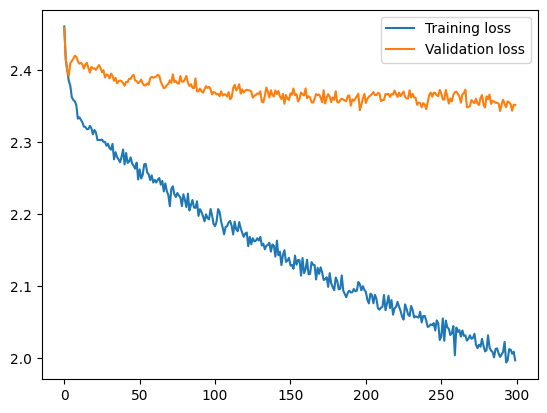

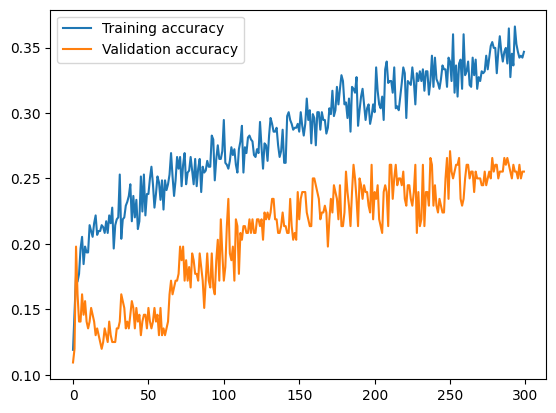

0.2708333333333333


In [23]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend()
plt.show()

print(max(val_accs))

In [24]:
model.eval()

predictions = []
with torch.no_grad():  
    for data in test_loader:
        inputs, labels = data
        
        # Forward pass
        outputs = model(inputs, edge_index, edge_attr)
        
        # Apply softmax if it's a classification problem (if outputs are logits)
        outputs = F.softmax(outputs, dim=1)
        
        # Get predicted class for each input
        _, predicted_classes = torch.max(outputs, 1)
        
        # Store predictions
        predictions.extend(predicted_classes.cpu().numpy())  # Convert to numpy for easier handling if needed

# predictions now contains the predicted classes for the test set
print(predictions)


[np.int64(4), np.int64(5), np.int64(4), np.int64(6), np.int64(6), np.int64(6), np.int64(10), np.int64(6), np.int64(10), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(6), np.int64(10), np.int64(5), np.int64(10), np.int64(5), np.int64(5), np.int64(5), np.int64(10), np.int64(5), np.int64(6), np.int64(10), np.int64(10), np.int64(6), np.int64(10), np.int64(5), np.int64(5), np.int64(6), np.int64(10), np.int64(10), np.int64(10), np.int64(4), np.int64(1), np.int64(4), np.int64(10), np.int64(2), np.int64(10), np.int64(10), np.int64(5), np.int64(10), np.int64(5), np.int64(5), np.int64(5), np.int64(3), np.int64(5), np.int64(6), np.int64(6), np.int64(10), np.int64(5), np.int64(1), np.int64(3), np.int64(5), np.int64(3), np.int64(5), np.int64(10), np.int64(3), np.int64(5), np.int64(5), np.int64(10), np.int64(3), np.int64(5), np.int64(6), np.int64(5), np.int64(5), np.int64(6), np.int64(1), np.int64(5), np.int64(5), np.int64(5), np.int64(4), np.int64(6), np.int64(5), np.int64(5), np.int

In [25]:
# Reshape predictions to a 2D array (the encoder expects a 2D array)
predictions_reshaped = np.array(predictions).reshape(-1, 1)

# Reverse the encoding to get the original disorder names
predicted_disorders = encoder.inverse_transform(predictions_reshaped)

# Flatten the result to get a 1D array
predicted_disorders = predicted_disorders.flatten()

print(predicted_disorders)

['Bipolar disorder' 'Depressive disorder' 'Bipolar disorder'
 'Healthy control' 'Healthy control' 'Healthy control' 'Schizophrenia'
 'Healthy control' 'Schizophrenia' 'Depressive disorder'
 'Depressive disorder' 'Depressive disorder' 'Depressive disorder'
 'Healthy control' 'Schizophrenia' 'Depressive disorder' 'Schizophrenia'
 'Depressive disorder' 'Depressive disorder' 'Depressive disorder'
 'Schizophrenia' 'Depressive disorder' 'Healthy control' 'Schizophrenia'
 'Schizophrenia' 'Healthy control' 'Schizophrenia' 'Depressive disorder'
 'Depressive disorder' 'Healthy control' 'Schizophrenia' 'Schizophrenia'
 'Schizophrenia' 'Bipolar disorder' 'Adjustment disorder'
 'Bipolar disorder' 'Schizophrenia' 'Alcohol use disorder' 'Schizophrenia'
 'Schizophrenia' 'Depressive disorder' 'Schizophrenia'
 'Depressive disorder' 'Depressive disorder' 'Depressive disorder'
 'Behavioral addiction disorder' 'Depressive disorder' 'Healthy control'
 'Healthy control' 'Schizophrenia' 'Depressive disorder'


In [ ]:
test_data['specific.disorder.class'] = predicted_disorders

cols = list(test_data.columns)  # Get the list of column names
cols.insert(1, cols.pop(cols.index('specific.disorder.class')))  # Move 'predicted_disorder' to the second position

test_data = test_data[cols]

test_data

,age,specific.disorder.class,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
ID,,,,,,,,,,,,,,,,,,,,,
17,33.42,Bipolar disorder,99.0,18.298852,20.727033,13.261675,15.886505,16.391555,15.863625,15.359015,...,47.369509,29.750462,36.199884,47.606010,25.949897,27.358598,35.594365,22.758717,29.935265,36.734639
28,21.00,Depressive disorder,96.0,19.582317,19.361081,12.474928,15.782731,17.765585,17.418443,16.471981,...,82.339470,59.173842,62.650658,60.135772,76.513270,47.052214,68.780315,36.348038,65.033239,44.962903
33,31.20,Bipolar disorder,77.0,8.586290,7.780097,10.988097,8.824057,13.117073,8.529997,8.336123,...,89.692658,54.274851,60.789694,69.561827,70.339738,50.588009,75.275265,43.897477,78.079657,60.430207
41,50.08,Healthy control,108.0,17.228763,14.103134,5.363740,10.093295,8.824650,10.681502,12.262173,...,87.727331,54.979820,81.987264,88.628318,66.455585,66.486936,83.386597,41.805748,69.200769,74.109527
48,27.19,Healthy control,84.0,7.642189,8.196870,6.707214,9.105748,11.767434,13.257652,6.630485,...,68.183641,47.030523,73.424824,72.641229,42.725536,53.852002,63.786830,43.858619,54.839180,69.820884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,23.00,Depressive disorder,105.0,10.557399,10.640725,8.103579,13.268817,12.922987,12.423703,9.504469,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
896,18.00,Depressive disorder,126.0,7.118342,7.155121,4.872178,5.204649,7.724356,6.590457,4.729273,...,79.101531,54.748457,57.731152,58.403747,67.378335,44.414445,64.463289,38.639553,81.742414,51.166259
917,29.85,Behavioral addiction disorder,94.0,14.772312,13.900519,12.114937,10.852271,12.677581,12.515724,11.737600,...,77.818976,32.052137,39.246541,51.043616,43.533589,28.652939,48.278680,14.527171,38.551138,61.346083


In [30]:
test_data

,age,specific.disorder.class,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
ID,,,,,,,,,,,,,,,,,,,,,
17,33.42,Bipolar disorder,99.0,18.298852,20.727033,13.261675,15.886505,16.391555,15.863625,15.359015,...,47.369509,29.750462,36.199884,47.606010,25.949897,27.358598,35.594365,22.758717,29.935265,36.734639
28,21.00,Depressive disorder,96.0,19.582317,19.361081,12.474928,15.782731,17.765585,17.418443,16.471981,...,82.339470,59.173842,62.650658,60.135772,76.513270,47.052214,68.780315,36.348038,65.033239,44.962903
33,31.20,Bipolar disorder,77.0,8.586290,7.780097,10.988097,8.824057,13.117073,8.529997,8.336123,...,89.692658,54.274851,60.789694,69.561827,70.339738,50.588009,75.275265,43.897477,78.079657,60.430207
41,50.08,Healthy control,108.0,17.228763,14.103134,5.363740,10.093295,8.824650,10.681502,12.262173,...,87.727331,54.979820,81.987264,88.628318,66.455585,66.486936,83.386597,41.805748,69.200769,74.109527
48,27.19,Healthy control,84.0,7.642189,8.196870,6.707214,9.105748,11.767434,13.257652,6.630485,...,68.183641,47.030523,73.424824,72.641229,42.725536,53.852002,63.786830,43.858619,54.839180,69.820884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,23.00,Depressive disorder,105.0,10.557399,10.640725,8.103579,13.268817,12.922987,12.423703,9.504469,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
896,18.00,Depressive disorder,126.0,7.118342,7.155121,4.872178,5.204649,7.724356,6.590457,4.729273,...,79.101531,54.748457,57.731152,58.403747,67.378335,44.414445,64.463289,38.639553,81.742414,51.166259
917,29.85,Behavioral addiction disorder,94.0,14.772312,13.900519,12.114937,10.852271,12.677581,12.515724,11.737600,...,77.818976,32.052137,39.246541,51.043616,43.533589,28.652939,48.278680,14.527171,38.551138,61.346083


In [31]:
main_disorder_data = pd.read_csv("Test_Set_EEG.csv", index_col=0)
test_data['main.disorder.class'] = main_disorder_data["main.disorder.class"].values

cols = list(test_data.columns)  # Get the list of column names
cols.insert(1, cols.pop(cols.index('main.disorder.class')))  # Move 'predicted_disorder' to the second position

test_data = test_data[cols]

In [32]:
test_data

,age,main.disorder.class,specific.disorder.class,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
ID,,,,,,,,,,,,,,,,,,,,,
17,33.42,Mood disorder,Bipolar disorder,99.0,18.298852,20.727033,13.261675,15.886505,16.391555,15.863625,...,47.369509,29.750462,36.199884,47.606010,25.949897,27.358598,35.594365,22.758717,29.935265,36.734639
28,21.00,Mood disorder,Depressive disorder,96.0,19.582317,19.361081,12.474928,15.782731,17.765585,17.418443,...,82.339470,59.173842,62.650658,60.135772,76.513270,47.052214,68.780315,36.348038,65.033239,44.962903
33,31.20,Mood disorder,Bipolar disorder,77.0,8.586290,7.780097,10.988097,8.824057,13.117073,8.529997,...,89.692658,54.274851,60.789694,69.561827,70.339738,50.588009,75.275265,43.897477,78.079657,60.430207
41,50.08,Healthy control,Healthy control,108.0,17.228763,14.103134,5.363740,10.093295,8.824650,10.681502,...,87.727331,54.979820,81.987264,88.628318,66.455585,66.486936,83.386597,41.805748,69.200769,74.109527
48,27.19,Healthy control,Healthy control,84.0,7.642189,8.196870,6.707214,9.105748,11.767434,13.257652,...,68.183641,47.030523,73.424824,72.641229,42.725536,53.852002,63.786830,43.858619,54.839180,69.820884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,23.00,Mood disorder,Depressive disorder,105.0,10.557399,10.640725,8.103579,13.268817,12.922987,12.423703,...,94.727123,73.994841,75.159075,72.479599,81.756815,74.578657,78.980627,60.508215,65.113378,69.238767
896,18.00,Healthy control,Depressive disorder,126.0,7.118342,7.155121,4.872178,5.204649,7.724356,6.590457,...,79.101531,54.748457,57.731152,58.403747,67.378335,44.414445,64.463289,38.639553,81.742414,51.166259
917,29.85,Addictive disorder,Behavioral addiction disorder,94.0,14.772312,13.900519,12.114937,10.852271,12.677581,12.515724,...,77.818976,32.052137,39.246541,51.043616,43.533589,28.652939,48.278680,14.527171,38.551138,61.346083


In [33]:
# Export the test DataFrame to a CSV file
test_data.to_csv('Final_Test_Set_EEG.csv', index=False)
